# READ

1. API is in User Variables for User in Environemtn Variables named "NEPTUNE_API_TOKEN"
2. If internet sucks, set mode to offline
4. When offline runs are saved locally, sync it with | neptune sync -p "New-Thesis/KFold-Test" --offline-only |
- make sure it is in venv mode | (venv) PS C:\Users\user\Documents\Machine-Learning-Hub-1\ImageClassification\Neptune-Thesis> |
5. Delete the offline folder or use | neptune clear |

# Load Libraries

In [1]:
import tqdm
import os
import cv2
import imghdr
import image_to_numpy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import itertools
from numpy.random import default_rng

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy
from tensorboard.plugins.hparams import api as hp
import sklearn
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold

from time import perf_counter
import math

import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

# Initialize Functions

In [2]:
model_name = "V4.0.1"
checkpoint_path = f'./checkpoints/{model_name}/FOLD-'

In [3]:
def make_model(params):
    model = Sequential()
    model.add(RandomFlip(mode='horizontal', seed=1, input_shape=(256,256,3)))
    model.add(RandomRotation(factor=0.2, seed=1))

    model.add(Conv2D(input_shape=(256,256,3), filters=16, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=128,activation="relu"))
    model.add(Dense(units=64,activation="relu"))

    model.add(Dense(units=4, activation="softmax"))

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=params["lr"],
    )
    
    model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
def create_callbacks(counter):
    neptune_cbk = NeptuneCallback(run=run, base_namespace="training")

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + str(counter), 
                                                                 monitor='val_loss', 
                                                                 mode='auto', 
                                                                 save_best_only=True, 
                                                                 verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                   patience=15,
                                                  )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                         factor=0.6, 
                                                         patience=5, 
                                                         min_delta=0.001, 
                                                         mode='auto', 
                                                         verbose=1)
    return [neptune_cbk, reduce_lr, cp_callback, es_callback]

In [6]:
def plot_loss(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    plt.suptitle('Loss')
    plt.legend(loc='upper right')
    plt.show()
    return fig

In [7]:
def plot_acc(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['accuracy'], color='teal', label='acc')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
    plt.suptitle('Accuracy')
    plt.legend(loc='upper left')
    plt.show()
    return fig

In [8]:
def avg_rate(metric_list):
    return sum(metric_list) / len(metric_list)

# Prepare Dataset

In [9]:
labels = ['Building', 'Plant', 'Road', 'Vehicle']
X_train = []
y_train = []
y_label_idx = []
image_size = 256
for i in labels:
    folderPath = os.path.join('D:\DATASETS\For-Thesis\Labels', i)
    for j in os.listdir(folderPath):
        img = image_to_numpy.load_image_file(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_label_idx.append(labels.index(i))

In [10]:
X_train = np.array(X_train)
y_label_idx = np.array(y_label_idx)

X_train_scaled = X_train.astype(np.float32) / 255.0

In [11]:
rng = default_rng(seed=1)

buildings_test_idx = rng.choice(np.arange(0,600), size=120, replace=False)
plants_test_idx = rng.choice(np.arange(600,1200), size=120, replace=False)
roads_test_idx = rng.choice(np.arange(1200,1800), size=120, replace=False)
vehicles_test_idx = rng.choice(np.arange(1800,2400), size=120, replace=False)
total_test_idx = np.concatenate((buildings_test_idx, plants_test_idx, roads_test_idx, vehicles_test_idx), axis=None)

In [12]:
def train_test_X(X_train_scaled):    
    test_x = X_train_scaled[total_test_idx]
    train_x = np.delete(X_train_scaled, total_test_idx, axis=0)
    return train_x, test_x

def train_test_y(y_label_idx):
    test_y = y_label_idx[total_test_idx]
    train_y = np.delete(y_label_idx, total_test_idx, axis=0)
    return train_y, test_y

In [14]:
train_x, holdout_x = train_test_X(X_train_scaled)
train_y, holdout_y = train_test_y(y_label_idx)

In [15]:
print(len(train_x), len(holdout_x))

1920 480


In [16]:
print(train_y[:5])

[0 0 0 0 0]


In [17]:
# Inidices remain the same thanks to the seed (set to 1)
# with open('total_test_idx.txt', 'w+') as f:
     
#     # write elements of list
#     for items in total_test_idx:
#         f.write('%s ' %items)
     
#     print("File written successfully")
 
 
# # close the file
# f.close()

In [18]:
# mnist = tf.keras.datasets.mnist
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train, x_test = x_train / 255.0, x_test / 255.0

# Run KFOLD

In [19]:
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=1)

In [20]:
project_name = "New-Thesis/KFold-Test"
# api_token = <It is already initialized in environemnt variables>
params = {
    "lr": 0.001, 
    "epochs": 25, 
    "batch_size": 8}

In [21]:
# run.stop()

[neptune] [warning] NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: offline/6d3ecedd-a464-4d62-bd21-f74bef635c9b



Epoch 1/25


210/210 [==============================] - ETA: 0s - loss: 2.2559 - accuracy: 0.5940
Epoch 1: val_loss improved from inf to 1.90102, saving model to ./checkpoints/V4.0.1\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-0\assets


210/210 [==============================] - 60s 253ms/step - loss: 2.2559 - accuracy: 0.5940 - val_loss: 1.9010 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 2/25
210/210 [==============================] - ETA: 0s - loss: 0.8313 - accuracy: 0.7125
Epoch 2: val_loss improved from 1.90102 to 1.02064, saving model to ./checkpoints/V4.0.1\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-0\assets


210/210 [==============================] - 56s 267ms/step - loss: 0.8313 - accuracy: 0.7125 - val_loss: 1.0206 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 3/25
210/210 [==============================] - ETA: 0s - loss: 0.7011 - accuracy: 0.7315
Epoch 3: val_loss improved from 1.02064 to 0.71046, saving model to ./checkpoints/V4.0.1\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-0\assets


210/210 [==============================] - 56s 266ms/step - loss: 0.7011 - accuracy: 0.7315 - val_loss: 0.7105 - val_accuracy: 0.7208 - lr: 0.0010
Epoch 4/25
210/210 [==============================] - ETA: 0s - loss: 0.6749 - accuracy: 0.7369
Epoch 4: val_loss improved from 0.71046 to 0.54733, saving model to ./checkpoints/V4.0.1\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-0\assets


210/210 [==============================] - 52s 246ms/step - loss: 0.6749 - accuracy: 0.7369 - val_loss: 0.5473 - val_accuracy: 0.7833 - lr: 0.0010
Epoch 5/25
210/210 [==============================] - ETA: 0s - loss: 0.5235 - accuracy: 0.7935
Epoch 5: val_loss did not improve from 0.54733
210/210 [==============================] - 41s 195ms/step - loss: 0.5235 - accuracy: 0.7935 - val_loss: 2.8636 - val_accuracy: 0.4250 - lr: 0.0010
Epoch 6/25
210/210 [==============================] - ETA: 0s - loss: 0.5467 - accuracy: 0.8000
Epoch 6: val_loss did not improve from 0.54733
210/210 [==============================] - 43s 205ms/step - loss: 0.5467 - accuracy: 0.8000 - val_loss: 1.7082 - val_accuracy: 0.5417 - lr: 0.0010
Epoch 7/25
210/210 [==============================] - ETA: 0s - loss: 0.4775 - accuracy: 0.8190
Epoch 7: val_loss did not improve from 0.54733
210/210 [==============================] - 44s 211ms/step - loss: 0.4775 - accuracy: 0.8190 - val_loss: 1.7322 - val_accuracy: 0.6

INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-0\assets


210/210 [==============================] - 47s 223ms/step - loss: 0.3808 - accuracy: 0.8595 - val_loss: 0.3816 - val_accuracy: 0.8708 - lr: 6.0000e-04
Epoch 11/25
210/210 [==============================] - ETA: 0s - loss: 0.3954 - accuracy: 0.8488
Epoch 11: val_loss did not improve from 0.38163
210/210 [==============================] - 37s 176ms/step - loss: 0.3954 - accuracy: 0.8488 - val_loss: 0.4311 - val_accuracy: 0.8458 - lr: 6.0000e-04
Epoch 12/25
210/210 [==============================] - ETA: 0s - loss: 0.3608 - accuracy: 0.8583
Epoch 12: val_loss did not improve from 0.38163
210/210 [==============================] - 38s 182ms/step - loss: 0.3608 - accuracy: 0.8583 - val_loss: 1.4129 - val_accuracy: 0.5708 - lr: 6.0000e-04
Epoch 13/25
210/210 [==============================] - ETA: 0s - loss: 0.3785 - accuracy: 0.8518
Epoch 13: val_loss did not improve from 0.38163
210/210 [==============================] - 42s 201ms/step - loss: 0.3785 - accuracy: 0.8518 - val_loss: 0.9860 -

INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-0\assets


210/210 [==============================] - 49s 234ms/step - loss: 0.2628 - accuracy: 0.8911 - val_loss: 0.3314 - val_accuracy: 0.8667 - lr: 3.6000e-04
Epoch 19/25
210/210 [==============================] - ETA: 0s - loss: 0.2706 - accuracy: 0.8994
Epoch 19: val_loss did not improve from 0.33143
210/210 [==============================] - 40s 192ms/step - loss: 0.2706 - accuracy: 0.8994 - val_loss: 0.5630 - val_accuracy: 0.8167 - lr: 3.6000e-04
Epoch 20/25
210/210 [==============================] - ETA: 0s - loss: 0.2759 - accuracy: 0.8946
Epoch 20: val_loss did not improve from 0.33143
210/210 [==============================] - 37s 176ms/step - loss: 0.2759 - accuracy: 0.8946 - val_loss: 0.4713 - val_accuracy: 0.8417 - lr: 3.6000e-04
Epoch 21/25
210/210 [==============================] - ETA: 0s - loss: 0.2948 - accuracy: 0.8929
Epoch 21: val_loss improved from 0.33143 to 0.30432, saving model to ./checkpoints/V4.0.1\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-0\

INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-0\assets


210/210 [==============================] - 48s 230ms/step - loss: 0.2948 - accuracy: 0.8929 - val_loss: 0.3043 - val_accuracy: 0.8875 - lr: 3.6000e-04
Epoch 22/25
210/210 [==============================] - ETA: 0s - loss: 0.2594 - accuracy: 0.9042
Epoch 22: val_loss did not improve from 0.30432
210/210 [==============================] - 42s 202ms/step - loss: 0.2594 - accuracy: 0.9042 - val_loss: 0.3847 - val_accuracy: 0.8542 - lr: 3.6000e-04
Epoch 23/25
210/210 [==============================] - ETA: 0s - loss: 0.2439 - accuracy: 0.9125
Epoch 23: val_loss did not improve from 0.30432
210/210 [==============================] - 37s 175ms/step - loss: 0.2439 - accuracy: 0.9125 - val_loss: 0.4070 - val_accuracy: 0.7958 - lr: 3.6000e-04
Epoch 24/25
210/210 [==============================] - ETA: 0s - loss: 0.2650 - accuracy: 0.9042
Epoch 24: val_loss improved from 0.30432 to 0.24866, saving model to ./checkpoints/V4.0.1\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-0\

INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-0\assets


210/210 [==============================] - 50s 240ms/step - loss: 0.2650 - accuracy: 0.9042 - val_loss: 0.2487 - val_accuracy: 0.9042 - lr: 3.6000e-04
Epoch 25/25
210/210 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.8958
Epoch 25: val_loss did not improve from 0.24866
210/210 [==============================] - 40s 189ms/step - loss: 0.2751 - accuracy: 0.8958 - val_loss: 1.3775 - val_accuracy: 0.5875 - lr: 3.6000e-04


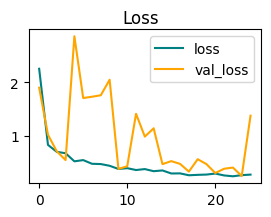

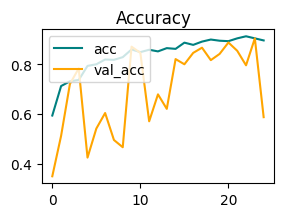

Fold Training Time: 0 hour(s) and 19 mins
Precision: 90.71729779243469  -  Recall: 89.58333134651184
Accuracy: 90.41666388511658
F1Score: Building 82.92683410644531 | Plant 95.86776733398438 | Road 97.52066040039062 | Vehicle 85.2173843383789
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/09fc0bb2-69fd-4555-8e12-de6d91fd79f7
Epoch 1/25
210/210 [==============================] - ETA: 0s - loss: 2.7724 - accuracy: 0.6071
Epoch 1: val_loss improved from inf to 6.66780, saving model to ./checkpoints/V4.0.1\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-1\assets


210/210 [==============================] - 51s 224ms/step - loss: 2.7724 - accuracy: 0.6071 - val_loss: 6.6678 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/25
210/210 [==============================] - ETA: 0s - loss: 0.7706 - accuracy: 0.7292
Epoch 2: val_loss improved from 6.66780 to 0.92495, saving model to ./checkpoints/V4.0.1\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-1\assets


210/210 [==============================] - 53s 254ms/step - loss: 0.7706 - accuracy: 0.7292 - val_loss: 0.9249 - val_accuracy: 0.6625 - lr: 0.0010
Epoch 3/25
210/210 [==============================] - ETA: 0s - loss: 0.7021 - accuracy: 0.7435
Epoch 3: val_loss did not improve from 0.92495
210/210 [==============================] - 47s 223ms/step - loss: 0.7021 - accuracy: 0.7435 - val_loss: 1.3192 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 4/25
210/210 [==============================] - ETA: 0s - loss: 0.5902 - accuracy: 0.7780
Epoch 4: val_loss did not improve from 0.92495
210/210 [==============================] - 47s 223ms/step - loss: 0.5902 - accuracy: 0.7780 - val_loss: 3.2343 - val_accuracy: 0.4875 - lr: 0.0010
Epoch 5/25
210/210 [==============================] - ETA: 0s - loss: 0.5223 - accuracy: 0.8125
Epoch 5: val_loss did not improve from 0.92495
210/210 [==============================] - 47s 224ms/step - loss: 0.5223 - accuracy: 0.8125 - val_loss: 1.1538 - val_accuracy: 0.5

INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-1\assets


210/210 [==============================] - 41s 197ms/step - loss: 0.4502 - accuracy: 0.8220 - val_loss: 0.3581 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 8/25
210/210 [==============================] - ETA: 0s - loss: 0.4615 - accuracy: 0.8167
Epoch 8: val_loss did not improve from 0.35812
210/210 [==============================] - 36s 169ms/step - loss: 0.4615 - accuracy: 0.8167 - val_loss: 0.4153 - val_accuracy: 0.8292 - lr: 0.0010
Epoch 9/25
210/210 [==============================] - ETA: 0s - loss: 0.4804 - accuracy: 0.8095
Epoch 9: val_loss did not improve from 0.35812
210/210 [==============================] - 36s 170ms/step - loss: 0.4804 - accuracy: 0.8095 - val_loss: 0.4593 - val_accuracy: 0.8458 - lr: 0.0010
Epoch 10/25
210/210 [==============================] - ETA: 0s - loss: 0.4659 - accuracy: 0.8345
Epoch 10: val_loss did not improve from 0.35812
210/210 [==============================] - 36s 169ms/step - loss: 0.4659 - accuracy: 0.8345 - val_loss: 0.9682 - val_accuracy: 0

INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-1\assets


210/210 [==============================] - 44s 208ms/step - loss: 0.2869 - accuracy: 0.8946 - val_loss: 0.2981 - val_accuracy: 0.8917 - lr: 3.6000e-04
Epoch 19/25
210/210 [==============================] - ETA: 0s - loss: 0.2406 - accuracy: 0.9012
Epoch 19: val_loss did not improve from 0.29812
210/210 [==============================] - 38s 183ms/step - loss: 0.2406 - accuracy: 0.9012 - val_loss: 0.3630 - val_accuracy: 0.8667 - lr: 3.6000e-04
Epoch 20/25
210/210 [==============================] - ETA: 0s - loss: 0.2356 - accuracy: 0.9155
Epoch 20: val_loss improved from 0.29812 to 0.28742, saving model to ./checkpoints/V4.0.1\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-1\assets


210/210 [==============================] - 50s 241ms/step - loss: 0.2356 - accuracy: 0.9155 - val_loss: 0.2874 - val_accuracy: 0.8667 - lr: 3.6000e-04
Epoch 21/25
210/210 [==============================] - ETA: 0s - loss: 0.2614 - accuracy: 0.8970
Epoch 21: val_loss did not improve from 0.28742
210/210 [==============================] - 38s 179ms/step - loss: 0.2614 - accuracy: 0.8970 - val_loss: 0.4185 - val_accuracy: 0.8542 - lr: 3.6000e-04
Epoch 22/25
210/210 [==============================] - ETA: 0s - loss: 0.2424 - accuracy: 0.9107
Epoch 22: val_loss did not improve from 0.28742
210/210 [==============================] - 40s 190ms/step - loss: 0.2424 - accuracy: 0.9107 - val_loss: 1.7372 - val_accuracy: 0.5792 - lr: 3.6000e-04
Epoch 23/25
210/210 [==============================] - ETA: 0s - loss: 0.2385 - accuracy: 0.9083
Epoch 23: val_loss did not improve from 0.28742
210/210 [==============================] - 39s 185ms/step - loss: 0.2385 - accuracy: 0.9083 - val_loss: 1.1074 -

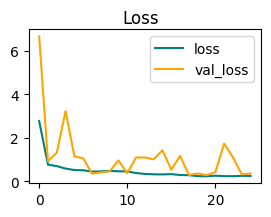

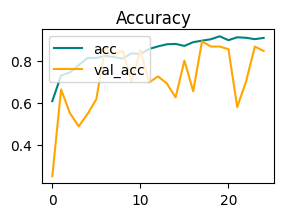

Fold Training Time: 0 hour(s) and 17 mins
Precision: 86.91983222961426  -  Recall: 85.83333492279053
Accuracy: 86.66666746139526
F1Score: Building 77.96610260009766 | Plant 91.47286224365234 | Road 94.01709747314453 | Vehicle 82.75862121582031
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/38fe551b-0ac2-4233-9390-1bd72ea97a5c
Epoch 1/25
210/210 [==============================] - ETA: 0s - loss: 1.8446 - accuracy: 0.5976
Epoch 1: val_loss improved from inf to 1.89938, saving model to ./checkpoints/V4.0.1\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-2\assets


210/210 [==============================] - 53s 229ms/step - loss: 1.8446 - accuracy: 0.5976 - val_loss: 1.8994 - val_accuracy: 0.3458 - lr: 0.0010
Epoch 2/25
210/210 [==============================] - ETA: 0s - loss: 0.7863 - accuracy: 0.7095
Epoch 2: val_loss improved from 1.89938 to 0.92523, saving model to ./checkpoints/V4.0.1\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-2\assets


210/210 [==============================] - 42s 198ms/step - loss: 0.7863 - accuracy: 0.7095 - val_loss: 0.9252 - val_accuracy: 0.6458 - lr: 0.0010
Epoch 3/25
210/210 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.7440
Epoch 3: val_loss improved from 0.92523 to 0.87981, saving model to ./checkpoints/V4.0.1\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-2\assets


210/210 [==============================] - 43s 203ms/step - loss: 0.6833 - accuracy: 0.7440 - val_loss: 0.8798 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 4/25
210/210 [==============================] - ETA: 0s - loss: 0.5831 - accuracy: 0.7673
Epoch 4: val_loss did not improve from 0.87981
210/210 [==============================] - 37s 178ms/step - loss: 0.5831 - accuracy: 0.7673 - val_loss: 1.5201 - val_accuracy: 0.5042 - lr: 0.0010
Epoch 5/25
210/210 [==============================] - ETA: 0s - loss: 0.5202 - accuracy: 0.8018
Epoch 5: val_loss did not improve from 0.87981
210/210 [==============================] - 38s 179ms/step - loss: 0.5202 - accuracy: 0.8018 - val_loss: 6.5224 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 6/25
210/210 [==============================] - ETA: 0s - loss: 0.5519 - accuracy: 0.8036
Epoch 6: val_loss did not improve from 0.87981
210/210 [==============================] - 37s 178ms/step - loss: 0.5519 - accuracy: 0.8036 - val_loss: 1.2653 - val_accuracy: 0.5

INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-2\assets


210/210 [==============================] - 43s 204ms/step - loss: 0.4862 - accuracy: 0.8190 - val_loss: 0.7172 - val_accuracy: 0.7833 - lr: 0.0010
Epoch 9/25
210/210 [==============================] - ETA: 0s - loss: 0.4705 - accuracy: 0.8238
Epoch 9: val_loss did not improve from 0.71723
210/210 [==============================] - 38s 179ms/step - loss: 0.4705 - accuracy: 0.8238 - val_loss: 0.8787 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 10/25
210/210 [==============================] - ETA: 0s - loss: 0.4402 - accuracy: 0.8286
Epoch 10: val_loss improved from 0.71723 to 0.69581, saving model to ./checkpoints/V4.0.1\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-2\assets


210/210 [==============================] - 43s 204ms/step - loss: 0.4402 - accuracy: 0.8286 - val_loss: 0.6958 - val_accuracy: 0.7542 - lr: 0.0010
Epoch 11/25
210/210 [==============================] - ETA: 0s - loss: 0.4361 - accuracy: 0.8310
Epoch 11: val_loss did not improve from 0.69581
210/210 [==============================] - 39s 187ms/step - loss: 0.4361 - accuracy: 0.8310 - val_loss: 0.7003 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 12/25
210/210 [==============================] - ETA: 0s - loss: 0.3586 - accuracy: 0.8631
Epoch 12: val_loss did not improve from 0.69581
210/210 [==============================] - 36s 173ms/step - loss: 0.3586 - accuracy: 0.8631 - val_loss: 1.3142 - val_accuracy: 0.5708 - lr: 0.0010
Epoch 13/25
210/210 [==============================] - ETA: 0s - loss: 0.4164 - accuracy: 0.8440
Epoch 13: val_loss improved from 0.69581 to 0.53611, saving model to ./checkpoints/V4.0.1\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-2\assets


210/210 [==============================] - 42s 198ms/step - loss: 0.4164 - accuracy: 0.8440 - val_loss: 0.5361 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 14/25
210/210 [==============================] - ETA: 0s - loss: 0.3887 - accuracy: 0.8673
Epoch 14: val_loss did not improve from 0.53611
210/210 [==============================] - 37s 174ms/step - loss: 0.3887 - accuracy: 0.8673 - val_loss: 4.1664 - val_accuracy: 0.4417 - lr: 0.0010
Epoch 15/25
210/210 [==============================] - ETA: 0s - loss: 0.3823 - accuracy: 0.8613
Epoch 15: val_loss did not improve from 0.53611
210/210 [==============================] - 37s 175ms/step - loss: 0.3823 - accuracy: 0.8613 - val_loss: 1.1229 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 16/25
210/210 [==============================] - ETA: 0s - loss: 0.3779 - accuracy: 0.8667
Epoch 16: val_loss did not improve from 0.53611
210/210 [==============================] - 36s 174ms/step - loss: 0.3779 - accuracy: 0.8667 - val_loss: 0.6416 - val_accurac

INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-2\assets


210/210 [==============================] - 41s 193ms/step - loss: 0.2622 - accuracy: 0.9006 - val_loss: 0.3564 - val_accuracy: 0.8792 - lr: 6.0000e-04
Epoch 20/25
210/210 [==============================] - ETA: 0s - loss: 0.2560 - accuracy: 0.9006
Epoch 20: val_loss did not improve from 0.35641
210/210 [==============================] - 35s 169ms/step - loss: 0.2560 - accuracy: 0.9006 - val_loss: 0.5596 - val_accuracy: 0.8208 - lr: 6.0000e-04
Epoch 21/25
210/210 [==============================] - ETA: 0s - loss: 0.2790 - accuracy: 0.8946
Epoch 21: val_loss did not improve from 0.35641
210/210 [==============================] - 36s 170ms/step - loss: 0.2790 - accuracy: 0.8946 - val_loss: 0.5575 - val_accuracy: 0.8333 - lr: 6.0000e-04
Epoch 22/25
210/210 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.9060
Epoch 22: val_loss did not improve from 0.35641
210/210 [==============================] - 37s 176ms/step - loss: 0.2513 - accuracy: 0.9060 - val_loss: 0.7098 -

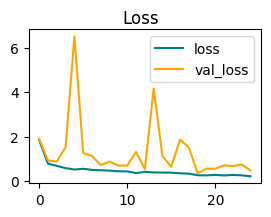

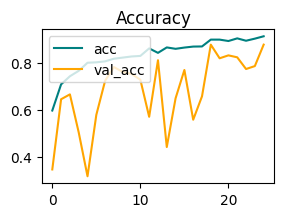

Fold Training Time: 0 hour(s) and 16 mins
Precision: 87.76371479034424  -  Recall: 86.66666746139526
Accuracy: 87.91666626930237
F1Score: Building 86.4000015258789 | Plant 89.39393615722656 | Road 88.8888931274414 | Vehicle 86.9565200805664
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/60294491-a32c-4a99-a274-0e2c3781492d
Epoch 1/25
210/210 [==============================] - ETA: 0s - loss: 1.5730 - accuracy: 0.6292
Epoch 1: val_loss improved from inf to 2.18379, saving model to ./checkpoints/V4.0.1\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-3\assets


210/210 [==============================] - 46s 201ms/step - loss: 1.5730 - accuracy: 0.6292 - val_loss: 2.1838 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/25
210/210 [==============================] - ETA: 0s - loss: 0.8285 - accuracy: 0.7030
Epoch 2: val_loss improved from 2.18379 to 1.22728, saving model to ./checkpoints/V4.0.1\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-3\assets


210/210 [==============================] - 40s 191ms/step - loss: 0.8285 - accuracy: 0.7030 - val_loss: 1.2273 - val_accuracy: 0.5167 - lr: 0.0010
Epoch 3/25
210/210 [==============================] - ETA: 0s - loss: 0.6523 - accuracy: 0.7446
Epoch 3: val_loss improved from 1.22728 to 0.65263, saving model to ./checkpoints/V4.0.1\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-3\assets


210/210 [==============================] - 40s 192ms/step - loss: 0.6523 - accuracy: 0.7446 - val_loss: 0.6526 - val_accuracy: 0.7083 - lr: 0.0010
Epoch 4/25
210/210 [==============================] - ETA: 0s - loss: 0.5610 - accuracy: 0.7786
Epoch 4: val_loss improved from 0.65263 to 0.56955, saving model to ./checkpoints/V4.0.1\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-3\assets


210/210 [==============================] - 44s 208ms/step - loss: 0.5610 - accuracy: 0.7786 - val_loss: 0.5696 - val_accuracy: 0.7583 - lr: 0.0010
Epoch 5/25
210/210 [==============================] - ETA: 0s - loss: 0.4836 - accuracy: 0.8119
Epoch 5: val_loss did not improve from 0.56955
210/210 [==============================] - 39s 188ms/step - loss: 0.4836 - accuracy: 0.8119 - val_loss: 1.3761 - val_accuracy: 0.5875 - lr: 0.0010
Epoch 6/25
210/210 [==============================] - ETA: 0s - loss: 0.5410 - accuracy: 0.7988
Epoch 6: val_loss improved from 0.56955 to 0.56031, saving model to ./checkpoints/V4.0.1\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-3\assets


210/210 [==============================] - 44s 211ms/step - loss: 0.5410 - accuracy: 0.7988 - val_loss: 0.5603 - val_accuracy: 0.7958 - lr: 0.0010
Epoch 7/25
210/210 [==============================] - ETA: 0s - loss: 0.4235 - accuracy: 0.8327
Epoch 7: val_loss did not improve from 0.56031
210/210 [==============================] - 40s 189ms/step - loss: 0.4235 - accuracy: 0.8327 - val_loss: 1.2070 - val_accuracy: 0.6417 - lr: 0.0010
Epoch 8/25
210/210 [==============================] - ETA: 0s - loss: 0.4289 - accuracy: 0.8393
Epoch 8: val_loss improved from 0.56031 to 0.42160, saving model to ./checkpoints/V4.0.1\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-3\assets


210/210 [==============================] - 46s 217ms/step - loss: 0.4289 - accuracy: 0.8393 - val_loss: 0.4216 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 9/25
210/210 [==============================] - ETA: 0s - loss: 0.4392 - accuracy: 0.8274
Epoch 9: val_loss did not improve from 0.42160
210/210 [==============================] - 40s 188ms/step - loss: 0.4392 - accuracy: 0.8274 - val_loss: 0.4914 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 10/25
210/210 [==============================] - ETA: 0s - loss: 0.3694 - accuracy: 0.8589
Epoch 10: val_loss did not improve from 0.42160
210/210 [==============================] - 39s 183ms/step - loss: 0.3694 - accuracy: 0.8589 - val_loss: 0.5723 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 11/25
210/210 [==============================] - ETA: 0s - loss: 0.4306 - accuracy: 0.8339
Epoch 11: val_loss did not improve from 0.42160
210/210 [==============================] - 40s 188ms/step - loss: 0.4306 - accuracy: 0.8339 - val_loss: 0.6320 - val_accuracy:

INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-3\assets


210/210 [==============================] - 41s 195ms/step - loss: 0.3860 - accuracy: 0.8560 - val_loss: 0.3485 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 14/25
210/210 [==============================] - ETA: 0s - loss: 0.3245 - accuracy: 0.8667
Epoch 14: val_loss did not improve from 0.34851
210/210 [==============================] - 39s 186ms/step - loss: 0.3245 - accuracy: 0.8667 - val_loss: 0.8090 - val_accuracy: 0.7583 - lr: 0.0010
Epoch 15/25
210/210 [==============================] - ETA: 0s - loss: 0.3620 - accuracy: 0.8649
Epoch 15: val_loss did not improve from 0.34851
210/210 [==============================] - 37s 176ms/step - loss: 0.3620 - accuracy: 0.8649 - val_loss: 0.6410 - val_accuracy: 0.7417 - lr: 0.0010
Epoch 16/25
210/210 [==============================] - ETA: 0s - loss: 0.3285 - accuracy: 0.8756
Epoch 16: val_loss did not improve from 0.34851
210/210 [==============================] - 39s 185ms/step - loss: 0.3285 - accuracy: 0.8756 - val_loss: 1.0874 - val_accurac

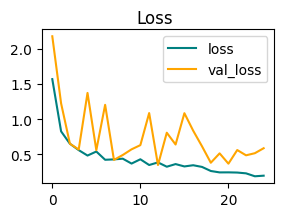

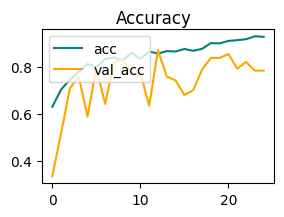

Fold Training Time: 0 hour(s) and 16 mins
Precision: 87.76371479034424  -  Recall: 86.66666746139526
Accuracy: 87.08333373069763
F1Score: Building 80.67227172851562 | Plant 91.47286224365234 | Road 92.98246002197266 | Vehicle 83.05084991455078
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/a860dde7-6a16-428b-b187-da337190394c
Epoch 1/25
210/210 [==============================] - ETA: 0s - loss: 2.0803 - accuracy: 0.5946
Epoch 1: val_loss improved from inf to 2.76596, saving model to ./checkpoints/V4.0.1\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-4\assets


210/210 [==============================] - 50s 218ms/step - loss: 2.0803 - accuracy: 0.5946 - val_loss: 2.7660 - val_accuracy: 0.2792 - lr: 0.0010
Epoch 2/25
210/210 [==============================] - ETA: 0s - loss: 0.7480 - accuracy: 0.7226
Epoch 2: val_loss improved from 2.76596 to 1.65915, saving model to ./checkpoints/V4.0.1\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-4\assets


210/210 [==============================] - 42s 200ms/step - loss: 0.7480 - accuracy: 0.7226 - val_loss: 1.6592 - val_accuracy: 0.3875 - lr: 0.0010
Epoch 3/25
210/210 [==============================] - ETA: 0s - loss: 0.6242 - accuracy: 0.7571
Epoch 3: val_loss improved from 1.65915 to 0.77363, saving model to ./checkpoints/V4.0.1\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-4\assets


210/210 [==============================] - 41s 196ms/step - loss: 0.6242 - accuracy: 0.7571 - val_loss: 0.7736 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 4/25
210/210 [==============================] - ETA: 0s - loss: 0.5518 - accuracy: 0.7887
Epoch 4: val_loss did not improve from 0.77363
210/210 [==============================] - 36s 170ms/step - loss: 0.5518 - accuracy: 0.7887 - val_loss: 0.8930 - val_accuracy: 0.6292 - lr: 0.0010
Epoch 5/25
210/210 [==============================] - ETA: 0s - loss: 0.5369 - accuracy: 0.7845
Epoch 5: val_loss improved from 0.77363 to 0.69136, saving model to ./checkpoints/V4.0.1\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-4\assets


210/210 [==============================] - 43s 205ms/step - loss: 0.5369 - accuracy: 0.7845 - val_loss: 0.6914 - val_accuracy: 0.7292 - lr: 0.0010
Epoch 6/25
210/210 [==============================] - ETA: 0s - loss: 0.5237 - accuracy: 0.8000
Epoch 6: val_loss did not improve from 0.69136
210/210 [==============================] - 41s 195ms/step - loss: 0.5237 - accuracy: 0.8000 - val_loss: 1.5688 - val_accuracy: 0.4958 - lr: 0.0010
Epoch 7/25
210/210 [==============================] - ETA: 0s - loss: 0.4910 - accuracy: 0.8125
Epoch 7: val_loss improved from 0.69136 to 0.54926, saving model to ./checkpoints/V4.0.1\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-4\assets


210/210 [==============================] - 50s 235ms/step - loss: 0.4910 - accuracy: 0.8125 - val_loss: 0.5493 - val_accuracy: 0.8083 - lr: 0.0010
Epoch 8/25
210/210 [==============================] - ETA: 0s - loss: 0.4758 - accuracy: 0.8155
Epoch 8: val_loss did not improve from 0.54926
210/210 [==============================] - 38s 182ms/step - loss: 0.4758 - accuracy: 0.8155 - val_loss: 1.0060 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 9/25
210/210 [==============================] - ETA: 0s - loss: 0.4995 - accuracy: 0.8107
Epoch 9: val_loss did not improve from 0.54926
210/210 [==============================] - 38s 180ms/step - loss: 0.4995 - accuracy: 0.8107 - val_loss: 1.0601 - val_accuracy: 0.6792 - lr: 0.0010
Epoch 10/25
210/210 [==============================] - ETA: 0s - loss: 0.4486 - accuracy: 0.8280
Epoch 10: val_loss did not improve from 0.54926
210/210 [==============================] - 41s 194ms/step - loss: 0.4486 - accuracy: 0.8280 - val_loss: 0.7756 - val_accuracy: 0

INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-4\assets


210/210 [==============================] - 45s 213ms/step - loss: 0.4359 - accuracy: 0.8399 - val_loss: 0.4133 - val_accuracy: 0.8917 - lr: 0.0010
Epoch 12/25
210/210 [==============================] - ETA: 0s - loss: 0.4121 - accuracy: 0.8464
Epoch 12: val_loss improved from 0.41330 to 0.38945, saving model to ./checkpoints/V4.0.1\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-4\assets


210/210 [==============================] - 44s 209ms/step - loss: 0.4121 - accuracy: 0.8464 - val_loss: 0.3895 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 13/25
210/210 [==============================] - ETA: 0s - loss: 0.4168 - accuracy: 0.8458
Epoch 13: val_loss did not improve from 0.38945
210/210 [==============================] - 39s 184ms/step - loss: 0.4168 - accuracy: 0.8458 - val_loss: 1.2309 - val_accuracy: 0.5958 - lr: 0.0010
Epoch 14/25
210/210 [==============================] - ETA: 0s - loss: 0.3650 - accuracy: 0.8619
Epoch 14: val_loss did not improve from 0.38945
210/210 [==============================] - 39s 185ms/step - loss: 0.3650 - accuracy: 0.8619 - val_loss: 0.6253 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 15/25
210/210 [==============================] - ETA: 0s - loss: 0.4179 - accuracy: 0.8524
Epoch 15: val_loss did not improve from 0.38945
210/210 [==============================] - 39s 188ms/step - loss: 0.4179 - accuracy: 0.8524 - val_loss: 0.8365 - val_accurac

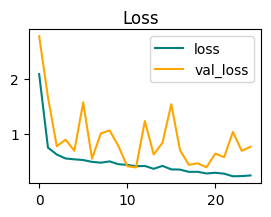

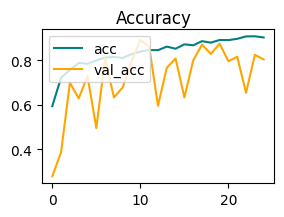

Fold Training Time: 0 hour(s) and 16 mins
Precision: 87.06896305084229  -  Recall: 84.16666388511658
Accuracy: 86.2500011920929
F1Score: Building 77.04918670654297 | Plant 89.6551742553711 | Road 95.23809814453125 | Vehicle 82.75862121582031
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/8c0da323-127e-475d-809d-86cb0def1c11
Epoch 1/25
210/210 [==============================] - ETA: 0s - loss: 2.7241 - accuracy: 0.5875
Epoch 1: val_loss improved from inf to 2.93816, saving model to ./checkpoints/V4.0.1\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-5\assets


210/210 [==============================] - 46s 199ms/step - loss: 2.7241 - accuracy: 0.5875 - val_loss: 2.9382 - val_accuracy: 0.4417 - lr: 0.0010
Epoch 2/25
210/210 [==============================] - ETA: 0s - loss: 0.9392 - accuracy: 0.7042
Epoch 2: val_loss improved from 2.93816 to 0.59593, saving model to ./checkpoints/V4.0.1\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-5\assets


210/210 [==============================] - 41s 194ms/step - loss: 0.9392 - accuracy: 0.7042 - val_loss: 0.5959 - val_accuracy: 0.7542 - lr: 0.0010
Epoch 3/25
210/210 [==============================] - ETA: 0s - loss: 0.7531 - accuracy: 0.7399
Epoch 3: val_loss improved from 0.59593 to 0.48217, saving model to ./checkpoints/V4.0.1\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-5\assets


210/210 [==============================] - 41s 197ms/step - loss: 0.7531 - accuracy: 0.7399 - val_loss: 0.4822 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 4/25
210/210 [==============================] - ETA: 0s - loss: 0.6338 - accuracy: 0.7619
Epoch 4: val_loss did not improve from 0.48217
210/210 [==============================] - 37s 176ms/step - loss: 0.6338 - accuracy: 0.7619 - val_loss: 0.9137 - val_accuracy: 0.7042 - lr: 0.0010
Epoch 5/25
210/210 [==============================] - ETA: 0s - loss: 0.5558 - accuracy: 0.7875
Epoch 5: val_loss did not improve from 0.48217
210/210 [==============================] - 37s 175ms/step - loss: 0.5558 - accuracy: 0.7875 - val_loss: 2.7597 - val_accuracy: 0.4625 - lr: 0.0010
Epoch 6/25
210/210 [==============================] - ETA: 0s - loss: 0.5637 - accuracy: 0.7827
Epoch 6: val_loss did not improve from 0.48217
210/210 [==============================] - 37s 176ms/step - loss: 0.5637 - accuracy: 0.7827 - val_loss: 1.0936 - val_accuracy: 0.5

INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-5\assets


210/210 [==============================] - 44s 211ms/step - loss: 0.4305 - accuracy: 0.8232 - val_loss: 0.3757 - val_accuracy: 0.8667 - lr: 6.0000e-04
Epoch 10/25
210/210 [==============================] - ETA: 0s - loss: 0.3824 - accuracy: 0.8399
Epoch 10: val_loss improved from 0.37571 to 0.33605, saving model to ./checkpoints/V4.0.1\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-5\assets


210/210 [==============================] - 44s 209ms/step - loss: 0.3824 - accuracy: 0.8399 - val_loss: 0.3360 - val_accuracy: 0.8875 - lr: 6.0000e-04
Epoch 11/25
210/210 [==============================] - ETA: 0s - loss: 0.3869 - accuracy: 0.8405
Epoch 11: val_loss did not improve from 0.33605
210/210 [==============================] - 37s 176ms/step - loss: 0.3869 - accuracy: 0.8405 - val_loss: 0.4127 - val_accuracy: 0.8542 - lr: 6.0000e-04
Epoch 12/25
210/210 [==============================] - ETA: 0s - loss: 0.3525 - accuracy: 0.8655
Epoch 12: val_loss did not improve from 0.33605
210/210 [==============================] - 37s 175ms/step - loss: 0.3525 - accuracy: 0.8655 - val_loss: 0.5222 - val_accuracy: 0.8125 - lr: 6.0000e-04
Epoch 13/25
210/210 [==============================] - ETA: 0s - loss: 0.4060 - accuracy: 0.8464
Epoch 13: val_loss did not improve from 0.33605
210/210 [==============================] - 38s 181ms/step - loss: 0.4060 - accuracy: 0.8464 - val_loss: 0.4011 -

INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-5\assets


210/210 [==============================] - 42s 200ms/step - loss: 0.3076 - accuracy: 0.8815 - val_loss: 0.3097 - val_accuracy: 0.8833 - lr: 3.6000e-04
Epoch 17/25
210/210 [==============================] - ETA: 0s - loss: 0.3046 - accuracy: 0.8899
Epoch 17: val_loss did not improve from 0.30968
210/210 [==============================] - 36s 173ms/step - loss: 0.3046 - accuracy: 0.8899 - val_loss: 0.6737 - val_accuracy: 0.7792 - lr: 3.6000e-04
Epoch 18/25
210/210 [==============================] - ETA: 0s - loss: 0.2719 - accuracy: 0.8970
Epoch 18: val_loss did not improve from 0.30968
210/210 [==============================] - 36s 173ms/step - loss: 0.2719 - accuracy: 0.8970 - val_loss: 0.4320 - val_accuracy: 0.8708 - lr: 3.6000e-04
Epoch 19/25
210/210 [==============================] - ETA: 0s - loss: 0.2903 - accuracy: 0.8792
Epoch 19: val_loss did not improve from 0.30968
210/210 [==============================] - 38s 182ms/step - loss: 0.2903 - accuracy: 0.8792 - val_loss: 0.7148 -

INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-5\assets


210/210 [==============================] - 42s 198ms/step - loss: 0.2415 - accuracy: 0.9173 - val_loss: 0.2795 - val_accuracy: 0.8958 - lr: 2.1600e-04
Epoch 23/25
210/210 [==============================] - ETA: 0s - loss: 0.2412 - accuracy: 0.9054
Epoch 23: val_loss did not improve from 0.27955
210/210 [==============================] - 37s 177ms/step - loss: 0.2412 - accuracy: 0.9054 - val_loss: 0.2870 - val_accuracy: 0.8917 - lr: 2.1600e-04
Epoch 24/25
210/210 [==============================] - ETA: 0s - loss: 0.2493 - accuracy: 0.9042
Epoch 24: val_loss did not improve from 0.27955
210/210 [==============================] - 39s 187ms/step - loss: 0.2493 - accuracy: 0.9042 - val_loss: 0.3340 - val_accuracy: 0.8750 - lr: 2.1600e-04
Epoch 25/25
210/210 [==============================] - ETA: 0s - loss: 0.2630 - accuracy: 0.9000
Epoch 25: val_loss did not improve from 0.27955
210/210 [==============================] - 37s 177ms/step - loss: 0.2630 - accuracy: 0.9000 - val_loss: 0.4071 -

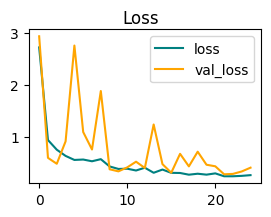

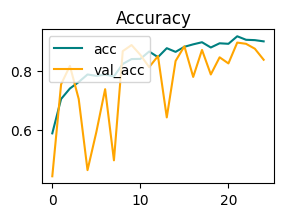

Fold Training Time: 0 hour(s) and 16 mins
Precision: 91.02563858032227  -  Recall: 88.7499988079071
Accuracy: 89.58333134651184
F1Score: Building 83.60655212402344 | Plant 91.93547821044922 | Road 94.21487426757812 | Vehicle 88.49556732177734
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/5db6e564-3f67-414f-a90d-2ee59bedc3f7
Epoch 1/25
210/210 [==============================] - ETA: 0s - loss: 1.7623 - accuracy: 0.6042
Epoch 1: val_loss improved from inf to 2.85527, saving model to ./checkpoints/V4.0.1\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-6\assets


210/210 [==============================] - 55s 243ms/step - loss: 1.7623 - accuracy: 0.6042 - val_loss: 2.8553 - val_accuracy: 0.4125 - lr: 0.0010
Epoch 2/25
210/210 [==============================] - ETA: 0s - loss: 0.7628 - accuracy: 0.6982
Epoch 2: val_loss improved from 2.85527 to 0.78671, saving model to ./checkpoints/V4.0.1\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-6\assets


210/210 [==============================] - 45s 216ms/step - loss: 0.7628 - accuracy: 0.6982 - val_loss: 0.7867 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 3/25
210/210 [==============================] - ETA: 0s - loss: 0.6623 - accuracy: 0.7381
Epoch 3: val_loss did not improve from 0.78671
210/210 [==============================] - 42s 201ms/step - loss: 0.6623 - accuracy: 0.7381 - val_loss: 1.2875 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 4/25
210/210 [==============================] - ETA: 0s - loss: 0.6209 - accuracy: 0.7607
Epoch 4: val_loss improved from 0.78671 to 0.74097, saving model to ./checkpoints/V4.0.1\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-6\assets


210/210 [==============================] - 46s 221ms/step - loss: 0.6209 - accuracy: 0.7607 - val_loss: 0.7410 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/25
210/210 [==============================] - ETA: 0s - loss: 0.5740 - accuracy: 0.7768
Epoch 5: val_loss improved from 0.74097 to 0.58954, saving model to ./checkpoints/V4.0.1\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-6\assets


210/210 [==============================] - 48s 231ms/step - loss: 0.5740 - accuracy: 0.7768 - val_loss: 0.5895 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 6/25
210/210 [==============================] - ETA: 0s - loss: 0.5502 - accuracy: 0.7911
Epoch 6: val_loss did not improve from 0.58954
210/210 [==============================] - 42s 200ms/step - loss: 0.5502 - accuracy: 0.7911 - val_loss: 2.2550 - val_accuracy: 0.4625 - lr: 0.0010
Epoch 7/25
210/210 [==============================] - ETA: 0s - loss: 0.4745 - accuracy: 0.8107
Epoch 7: val_loss did not improve from 0.58954
210/210 [==============================] - 41s 197ms/step - loss: 0.4745 - accuracy: 0.8107 - val_loss: 0.6224 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 8/25
210/210 [==============================] - ETA: 0s - loss: 0.4925 - accuracy: 0.8036
Epoch 8: val_loss did not improve from 0.58954
210/210 [==============================] - 40s 190ms/step - loss: 0.4925 - accuracy: 0.8036 - val_loss: 1.1679 - val_accuracy: 0.6

INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-6\assets


210/210 [==============================] - 47s 223ms/step - loss: 0.3665 - accuracy: 0.8494 - val_loss: 0.4994 - val_accuracy: 0.8750 - lr: 6.0000e-04
Epoch 14/25
210/210 [==============================] - ETA: 0s - loss: 0.3223 - accuracy: 0.8762
Epoch 14: val_loss did not improve from 0.49944
210/210 [==============================] - 36s 173ms/step - loss: 0.3223 - accuracy: 0.8762 - val_loss: 0.6070 - val_accuracy: 0.8083 - lr: 6.0000e-04
Epoch 15/25
210/210 [==============================] - ETA: 0s - loss: 0.3584 - accuracy: 0.8601
Epoch 15: val_loss improved from 0.49944 to 0.46661, saving model to ./checkpoints/V4.0.1\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-6\assets


210/210 [==============================] - 51s 245ms/step - loss: 0.3584 - accuracy: 0.8601 - val_loss: 0.4666 - val_accuracy: 0.8417 - lr: 6.0000e-04
Epoch 16/25
210/210 [==============================] - ETA: 0s - loss: 0.3126 - accuracy: 0.8726
Epoch 16: val_loss did not improve from 0.46661
210/210 [==============================] - 43s 207ms/step - loss: 0.3126 - accuracy: 0.8726 - val_loss: 1.0677 - val_accuracy: 0.6417 - lr: 6.0000e-04
Epoch 17/25
210/210 [==============================] - ETA: 0s - loss: 0.3065 - accuracy: 0.8750
Epoch 17: val_loss did not improve from 0.46661
210/210 [==============================] - 45s 215ms/step - loss: 0.3065 - accuracy: 0.8750 - val_loss: 1.1049 - val_accuracy: 0.6500 - lr: 6.0000e-04
Epoch 18/25
210/210 [==============================] - ETA: 0s - loss: 0.3148 - accuracy: 0.8708
Epoch 18: val_loss did not improve from 0.46661
210/210 [==============================] - 46s 218ms/step - loss: 0.3148 - accuracy: 0.8708 - val_loss: 1.3337 -

INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-6\assets


210/210 [==============================] - 51s 242ms/step - loss: 0.2394 - accuracy: 0.9107 - val_loss: 0.4566 - val_accuracy: 0.8750 - lr: 3.6000e-04
Epoch 25/25
210/210 [==============================] - ETA: 0s - loss: 0.2640 - accuracy: 0.8970
Epoch 25: val_loss did not improve from 0.45659
210/210 [==============================] - 44s 208ms/step - loss: 0.2640 - accuracy: 0.8970 - val_loss: 0.7592 - val_accuracy: 0.7875 - lr: 3.6000e-04


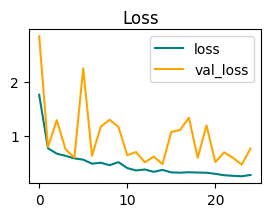

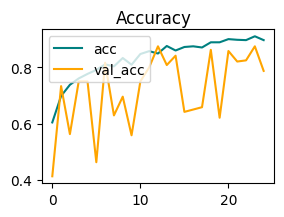

Fold Training Time: 0 hour(s) and 18 mins
Precision: 88.55932354927063  -  Recall: 87.08333373069763
Accuracy: 87.5
F1Score: Building 83.05084991455078 | Plant 89.07563018798828 | Road 91.80328369140625 | Vehicle 85.9504165649414
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/280675e4-6219-48c4-820a-27cd8ca60468
Epoch 1/25
210/210 [==============================] - ETA: 0s - loss: 2.6065 - accuracy: 0.5917
Epoch 1: val_loss improved from inf to 3.24507, saving model to ./checkpoints/V4.0.1\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-7\assets


210/210 [==============================] - 56s 235ms/step - loss: 2.6065 - accuracy: 0.5917 - val_loss: 3.2451 - val_accuracy: 0.2542 - lr: 0.0010
Epoch 2/25
210/210 [==============================] - ETA: 0s - loss: 0.8975 - accuracy: 0.7131
Epoch 2: val_loss improved from 3.24507 to 1.23182, saving model to ./checkpoints/V4.0.1\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-7\assets


210/210 [==============================] - 51s 242ms/step - loss: 0.8975 - accuracy: 0.7131 - val_loss: 1.2318 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 3/25
210/210 [==============================] - ETA: 0s - loss: 0.6396 - accuracy: 0.7524
Epoch 3: val_loss improved from 1.23182 to 0.48504, saving model to ./checkpoints/V4.0.1\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-7\assets


210/210 [==============================] - 50s 238ms/step - loss: 0.6396 - accuracy: 0.7524 - val_loss: 0.4850 - val_accuracy: 0.8042 - lr: 0.0010
Epoch 4/25
210/210 [==============================] - ETA: 0s - loss: 0.5828 - accuracy: 0.7720
Epoch 4: val_loss did not improve from 0.48504
210/210 [==============================] - 45s 217ms/step - loss: 0.5828 - accuracy: 0.7720 - val_loss: 0.6006 - val_accuracy: 0.7625 - lr: 0.0010
Epoch 5/25
210/210 [==============================] - ETA: 0s - loss: 0.4775 - accuracy: 0.8125
Epoch 5: val_loss did not improve from 0.48504
210/210 [==============================] - 43s 202ms/step - loss: 0.4775 - accuracy: 0.8125 - val_loss: 3.4474 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 6/25
210/210 [==============================] - ETA: 0s - loss: 0.4940 - accuracy: 0.7982
Epoch 6: val_loss did not improve from 0.48504
210/210 [==============================] - 45s 213ms/step - loss: 0.4940 - accuracy: 0.7982 - val_loss: 5.1170 - val_accuracy: 0.3

INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-7\assets


210/210 [==============================] - 44s 212ms/step - loss: 0.4665 - accuracy: 0.8333 - val_loss: 0.4575 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 9/25
210/210 [==============================] - ETA: 0s - loss: 0.4363 - accuracy: 0.8238
Epoch 9: val_loss did not improve from 0.45745
210/210 [==============================] - 37s 175ms/step - loss: 0.4363 - accuracy: 0.8238 - val_loss: 1.3017 - val_accuracy: 0.6292 - lr: 0.0010
Epoch 10/25
210/210 [==============================] - ETA: 0s - loss: 0.4025 - accuracy: 0.8393
Epoch 10: val_loss did not improve from 0.45745
210/210 [==============================] - 37s 174ms/step - loss: 0.4025 - accuracy: 0.8393 - val_loss: 3.2516 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 11/25
210/210 [==============================] - ETA: 0s - loss: 0.3889 - accuracy: 0.8524
Epoch 11: val_loss did not improve from 0.45745
210/210 [==============================] - 40s 191ms/step - loss: 0.3889 - accuracy: 0.8524 - val_loss: 0.4871 - val_accuracy:

INFO:tensorflow:Assets written to: ./checkpoints/V4.0.1\FOLD-7\assets


210/210 [==============================] - 51s 245ms/step - loss: 0.3060 - accuracy: 0.8804 - val_loss: 0.4258 - val_accuracy: 0.8417 - lr: 6.0000e-04
Epoch 15/25
210/210 [==============================] - ETA: 0s - loss: 0.3246 - accuracy: 0.8690
Epoch 15: val_loss did not improve from 0.42584
210/210 [==============================] - 43s 207ms/step - loss: 0.3246 - accuracy: 0.8690 - val_loss: 0.8222 - val_accuracy: 0.7292 - lr: 6.0000e-04
Epoch 16/25
210/210 [==============================] - ETA: 0s - loss: 0.2838 - accuracy: 0.8821
Epoch 16: val_loss did not improve from 0.42584
210/210 [==============================] - 43s 206ms/step - loss: 0.2838 - accuracy: 0.8821 - val_loss: 0.5873 - val_accuracy: 0.8375 - lr: 6.0000e-04
Epoch 17/25
210/210 [==============================] - ETA: 0s - loss: 0.2427 - accuracy: 0.9083
Epoch 17: val_loss did not improve from 0.42584
210/210 [==============================] - 35s 167ms/step - loss: 0.2427 - accuracy: 0.9083 - val_loss: 0.5472 -

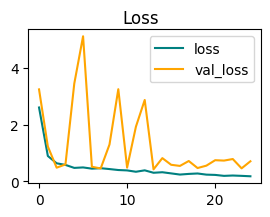

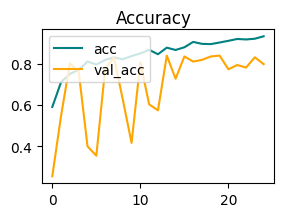

Fold Training Time: 0 hour(s) and 17 mins
Precision: 85.83691120147705  -  Recall: 83.33333134651184
Accuracy: 84.16666388511658
F1Score: Building 75.9259262084961 | Plant 84.05797576904297 | Road 93.80530548095703 | Vehicle 82.64462280273438
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
Total Training Time: 2 hour(s) and 21 mins


In [22]:
# ============================
# Log performance of each fold
# ============================

precisions = []
recalls = []
accuracies = []
f1_blds = []
f1_plants = []
f1_roads = []
f1_vhcls = []

counter = 0
start = perf_counter()
for train, test in kfold.split(train_x, train_y):
    start_fold = perf_counter()

    run = neptune.init_run(
        name= f"{model_name}-FOLD_{counter}",
        project=project_name,
        mode="offline"     # To prevent issue when internet sucks. Just manually sync it
    )  # your credentials

    run["parameters"] = params
    model = make_model(params)
    cat_y = tf.keras.utils.to_categorical(train_y)
    train_dataset = tf.data.Dataset.from_tensor_slices((train_x[train], cat_y[train]))
    train_fold = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), seed=1).batch(params['batch_size'])
    
    test_dataset = tf.data.Dataset.from_tensor_slices((train_x[test], cat_y[test]))
    test_fold = test_dataset.shuffle(buffer_size=test_dataset.cardinality(), seed=1).batch(params['batch_size'])
    
    hist = model.fit(train_fold, 
                     validation_data=test_fold,
                     batch_size=params['batch_size'],
                     epochs=params['epochs'],
                     verbose=1,
                     callbacks=create_callbacks(counter))
    end_fold = perf_counter()

    # PLOTTING ==================================================
    run["fig-train_loss"].upload(plot_loss(hist))
    run["fig-train_acc"].upload(plot_acc(hist))
    
    # EVALUATING ==================================================
    model = tf.keras.models.load_model(checkpoint_path + str(counter))
    
    pre = Precision()
    rec = Recall()
    c_acc = CategoricalAccuracy()
    f1_score = F1Score()
    for batch in test_fold.as_numpy_iterator():
        X, y = batch
        yhat = model.predict(X, verbose=0)
        f1_score.update_state(y, yhat)
        pre.update_state(y, yhat)
        rec.update_state(y, yhat)
        c_acc.update_state(y, yhat)
        
    precisions.append(pre.result().numpy() * 100)
    recalls.append(rec.result().numpy() * 100)
    accuracies.append(c_acc.result().numpy() * 100)
    f1_s = f1_score.result().numpy() * 100
    
    f1_blds.append(f1_s[0])
    f1_plants.append(f1_s[1])
    f1_roads.append(f1_s[2])
    f1_vhcls.append(f1_s[3])
    
    run["eval/ACC/"] = accuracies[counter]
    run["eval/REC/"] = recalls[counter]
    run["eval/PRE/"] = precisions[counter]
    run["eval/F1-Bld"] = f1_blds[counter]
    run["eval/F1-Plant"] = f1_plants[counter]
    run["eval/F1-Road"] = f1_roads[counter]
    run["eval/F1-Vhcl"] = f1_vhcls[counter]
    
    # PRINTING RESULTS ===========================================
    print(f'Fold Training Time: {math.floor((end_fold-start_fold)/3600) } hour(s) and {math.floor((end_fold-start_fold)/60)%60} mins')
    print(f'Precision: {precisions[counter]}  -  Recall: {recalls[counter]}')
    print(f'Accuracy: {accuracies[counter]}')
    print(f'F1Score: Building {f1_blds[counter]} | Plant {f1_plants[counter]} | Road {f1_roads[counter]} | Vehicle {f1_vhcls[counter]}')
    
    run.stop()
    
    counter += 1

end = perf_counter()

print(f'Total Training Time: {math.floor((end-start)/3600) } hour(s) and {math.floor((end-start)/60)%60} mins')

# Get Average Performance of Model

## Save to Neptune AI

In [23]:
run = neptune.init_run(
        name= f"{model_name}-AVG",
        project=project_name,
        mode='offline',
        # api_token=api_token, # Api token is saved in user's environemnt variables
    )  # your credentials

run["eval/PRE/"] = avg_rate(precisions)
run["eval/REC/"] = avg_rate(recalls)
run["eval/ACC/"] = avg_rate(accuracies)
run["eval/F1-Bld"] = avg_rate(f1_blds)
run["eval/F1-Plant"] = avg_rate(f1_plants)
run["eval/F1-Road"] = avg_rate(f1_roads)
run["eval/F1-Vhcl"] = avg_rate(f1_vhcls)

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: offline/95e0cb19-52fb-4fbd-bab0-a0b5d4828bd9
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!


## Save to Tensorboard

In [24]:
# Command to access TensorBoard HParams:

# tensorboard --logdir PATH/logs/hparam_tuning
with tf.summary.create_file_writer(f'./logs/hparam_tuning/{model_name}').as_default():
    hparams = {
        'CONV_F1': 16,
        'CONV_F2': 16,
        'CONV_F3': 32,
        'DROPOUT': 0.2,
        'D_UNITS_1': 128,
        'D_UNITS_2': 64,
    }
    hp.hparams(hparams)
    tf.summary.scalar('PRE', avg_rate(precisions), step=1)
    tf.summary.scalar('REC', avg_rate(recalls), step=1)
    tf.summary.scalar('ACC', avg_rate(accuracies), step=1)
    tf.summary.scalar('F1 - Building', avg_rate(f1_blds), step=1)
    tf.summary.scalar('F1 - Plant', avg_rate(f1_plants), step=1)
    tf.summary.scalar('F1 - Road', avg_rate(f1_roads), step=1)
    tf.summary.scalar('F1 - Vehicle', avg_rate(f1_vhcls), step=1)

# Asd

# Others

In [ ]:
model= make_model()
model.fit(
    x_train,
    y_train,
    validation_data=(x_test,y_test),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    callbacks=create_callbacks(0),
)

In [ ]:
true_test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
true_test_set = true_test_dataset.shuffle(buffer_size=true_test_dataset.cardinality(), seed=1).batch(64)

f1 = F1Score()
pre = Precision()
rec = Recall()
c_acc = CategoricalAccuracy()
for batch in true_test_set.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat_max = []
    for i in yhat:
        maxed = np.argmax(i)
        yhat_max.append(maxed)
    yhat = np.array(yhat_max)
    f1.update_state(y, yhat)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    c_acc.update_state(y, yhat)


In [ ]:
run["eval/ACC/"] = float(c_acc.result().numpy() * 100)
run["eval/REC/"] = float(rec.result().numpy() * 100)
run["eval/PRE/"] = float(pre.result().numpy() * 100)


In [ ]:
run.stop()

In [ ]:
eval_metrics = model.evaluate(x_test, y_test, verbose=0)
for j, metric in enumerate(eval_metrics):
    run["eval/AVG-ACC/{}".format(model.metrics_names[j])] = metric

run.stop()

In [ ]:
for j, metric in enumerate(eval_metrics):
    print(model.metrics_names[j])

## Neptune AI Notes